<a href="https://colab.research.google.com/github/iskra3138/ImageSr/blob/master/2_TFRecord_%ED%8C%8C%EC%9D%BC_%EB%A7%8C%EB%93%A4%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고 : https://codelabs.developers.google.com/codelabs/keras-flowers-data/#4

5종의 꽃 이미지 데이터를 TFRecord로 만드는 예제 코드입니다.

In [1]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf
import os, sys, math
import numpy as np
from matplotlib import pyplot as plt

In [3]:
!apt-get install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tree is already the newest version (1.7.0-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
#@title "display utilities [RUN ME]"
def display_9_images_from_dataset(dataset):
  plt.figure(figsize=(13,13))
  subplot=331
  for i, (image, label) in enumerate(dataset):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image.numpy().astype(np.uint8))
    plt.title(label.numpy().decode("utf-8"), fontsize=16)
    subplot += 1
    if i==8:
      break
  plt.tight_layout()
  plt.subplots_adjust(wspace=0.1, hspace=0.1)
  plt.show()

## The flowers dataset

The flowers dataset consists of images of flowers with 5 possible class labels.

When training a machine learning model, we split our data into training and test datasets. We will train the model on our training data and then evaluate how well the model performs on data it has never seen - the test set.

In [0]:
from pathlib import Path
data_dir = tf.keras.utils.get_file(origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
                                         fname='flower_photos', untar=True)
data_dir = Path(data_dir)

In [5]:
!tree -d {str(data_dir)}

/root/.keras/datasets/flower_photos
├── daisy
├── dandelion
├── roses
├── sunflowers
└── tulips

5 directories


In [0]:
SHARDS = 16 # TFRecord 파일을 16개 만들겠음
TARGET_SIZE = [224, 224]
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # do not change, maps to the labels in the data (folder names)

AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

DataSet나누고 TFRecord 만들기

In [7]:
import math

nb_images = len(tf.io.gfile.glob(str(Path(data_dir / '*/*.jpg')))) # 총 이미지 데이터 수 count
shard_size = math.ceil(1.0 * nb_images / SHARDS)
print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.


In [0]:
'''def decode_jpeg_and_label(filename):
  bits = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(bits)
  
  # parse flower name from containing directory
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  return bits, label

filenames = tf.data.Dataset.list_files(str(Path(data_dir / '*/*.jpg')), seed=35155) # This also shuffles the images
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)'''

In [0]:
def read_file_and_label(filename):
  bits = tf.io.read_file(filename)
  #image = tf.image.decode_jpeg(bits)
  
  # parse flower name from containing directory
  label = tf.strings.split(tf.expand_dims(filename, axis=-1), sep='/')
  label = label.values[-2]
  
  return bits, label

filenames = tf.data.Dataset.list_files(str(Path(data_dir / '*/*.jpg')), seed=35155) # This also shuffles the images
dataset1 = filenames.map(read_file_and_label, num_parallel_calls=AUTO)
dataset1 = dataset1.batch(shard_size)

In [0]:
'''def resize_and_crop_image(image, label):
  # Resize and crop using "fill" algorithm:
  # always make sure the resulting image
  # is cut out from the source image so that
  # it fills the TARGET_SIZE entirely with no
  # black bars and a preserved aspect ratio.
  w = tf.shape(image)[0]
  h = tf.shape(image)[1]
  tw = TARGET_SIZE[1]
  th = TARGET_SIZE[0]
  resize_crit = (w * th) / (h * tw)
  image = tf.cond(resize_crit < 1,
                  lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                  lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                 )
  nw = tf.shape(image)[0]
  nh = tf.shape(image)[1]
  image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
  return image, label'''

'''def resize_image(image, label):
  image = tf.image.resize(image,TARGET_SIZE)
  return image, label

#dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  
dataset2 = dataset1.map(resize_image, num_parallel_calls=AUTO)
'''

In [0]:
'''def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file '''

In [10]:
# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label):  
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "label": _bytestring_feature([label]),     # fixed length (1) list of strings, the text label
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")

for shard, (bits, label) in enumerate(dataset1):
  # batch size used as shard size here
  shard_size = bits.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = './' + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            bits.numpy()[i], 
                            label.numpy()[i]
                            )
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

Writing TFRecords
Wrote file ./00-230.tfrec containing 230 records
Wrote file ./01-230.tfrec containing 230 records
Wrote file ./02-230.tfrec containing 230 records
Wrote file ./03-230.tfrec containing 230 records
Wrote file ./04-230.tfrec containing 230 records
Wrote file ./05-230.tfrec containing 230 records
Wrote file ./06-230.tfrec containing 230 records
Wrote file ./07-230.tfrec containing 230 records
Wrote file ./08-230.tfrec containing 230 records
Wrote file ./09-230.tfrec containing 230 records
Wrote file ./10-230.tfrec containing 230 records
Wrote file ./11-230.tfrec containing 230 records
Wrote file ./12-230.tfrec containing 230 records
Wrote file ./13-230.tfrec containing 230 records
Wrote file ./14-230.tfrec containing 230 records
Wrote file ./15-220.tfrec containing 220 records


In [0]:
'''# Three types of data can be stored in TFRecords: bytestrings, integers and floats
# They are always stored as lists, a single data element will be a list of size 1

def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))

def _float_feature(list_of_floats): # float32
  return tf.train.Feature(float_list=tf.train.FloatList(value=list_of_floats))
  

def to_tfrecord(tfrec_filewriter, img_bytes, label, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses

  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]),        # one class in the list
      
      # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
      "label":         _bytestring_feature([label]),          # fixed length (1) list of strings, the text label
      "size":          _int_feature([height, width]),         # fixed length (2) list of ints
      "one_hot_class": _float_feature(one_hot_class.tolist()) # variable length  list of floats, n=len(CLASSES)
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")

for shard, (image, label) in enumerate(dataset2):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = './' + "{:02d}-{}.tfrec".format(shard, shard_size)
  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i],
                            height.numpy()[i],
                            width.numpy()[i])
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))'''

In [12]:
ll ./

total 227276
-rw-r--r-- 1 root 14354792 Feb 11 07:17 00-230.tfrec
-rw-r--r-- 1 root 14588788 Feb 11 07:17 01-230.tfrec
-rw-r--r-- 1 root 15092455 Feb 11 07:17 02-230.tfrec
-rw-r--r-- 1 root 14479827 Feb 11 07:17 03-230.tfrec
-rw-r--r-- 1 root 14682155 Feb 11 07:17 04-230.tfrec
-rw-r--r-- 1 root 13708394 Feb 11 07:17 05-230.tfrec
-rw-r--r-- 1 root 14751243 Feb 11 07:17 06-230.tfrec
-rw-r--r-- 1 root 15539018 Feb 11 07:17 07-230.tfrec
-rw-r--r-- 1 root 13911028 Feb 11 07:17 08-230.tfrec
-rw-r--r-- 1 root 15108314 Feb 11 07:17 09-230.tfrec
-rw-r--r-- 1 root 15462115 Feb 11 07:17 10-230.tfrec
-rw-r--r-- 1 root 14200960 Feb 11 07:17 11-230.tfrec
-rw-r--r-- 1 root 14079529 Feb 11 07:17 12-230.tfrec
-rw-r--r-- 1 root 14812344 Feb 11 07:17 13-230.tfrec
-rw-r--r-- 1 root 14655743 Feb 11 07:17 14-230.tfrec
-rw-r--r-- 1 root 13263838 Feb 11 07:18 15-220.tfrec
drwxr-xr-x 1 root     4096 Feb  5 18:37 sample_data/


In [11]:
total 119496
-rw-r--r-- 1 root 7537572 Feb 11 06:51 00-230.tfrec
-rw-r--r-- 1 root 7803363 Feb 11 06:51 01-230.tfrec
-rw-r--r-- 1 root 7874669 Feb 11 06:51 02-230.tfrec
-rw-r--r-- 1 root 8134630 Feb 11 06:51 03-230.tfrec
-rw-r--r-- 1 root 7571367 Feb 11 06:51 04-230.tfrec
-rw-r--r-- 1 root 7736467 Feb 11 06:51 05-230.tfrec
-rw-r--r-- 1 root 7859817 Feb 11 06:51 06-230.tfrec
-rw-r--r-- 1 root 7299537 Feb 11 06:51 07-230.tfrec
-rw-r--r-- 1 root 7680263 Feb 11 06:51 08-230.tfrec
-rw-r--r-- 1 root 7474854 Feb 11 06:51 09-230.tfrec
-rw-r--r-- 1 root 7597383 Feb 11 06:51 10-230.tfrec
-rw-r--r-- 1 root 7537876 Feb 11 06:51 11-230.tfrec
-rw-r--r-- 1 root 7728161 Feb 11 06:51 12-230.tfrec
-rw-r--r-- 1 root 7635453 Feb 11 06:51 13-230.tfrec
-rw-r--r-- 1 root 7608965 Feb 11 06:51 14-230.tfrec
-rw-r--r-- 1 root 7246526 Feb 11 06:51 15-220.tfrec
drwxr-xr-x 1 root    4096 Feb  5 18:37 sample_data/

SyntaxError: ignored

In [0]:
def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    #image = tf.reshape(image, [*TARGET_SIZE, 3])
    image = tf.image.resize(image, TARGET_SIZE)
    
    
    label  = example['label']
    
    return image, label
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob("./*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)

In [0]:
'''def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64),   # shape [] means scalar
        
        # additional (not very useful) fields to demonstrate TFRecord writing/reading of different types of data
        "label":         tf.io.FixedLenFeature([], tf.string),  # one bytestring
        "size":          tf.io.FixedLenFeature([2], tf.int64),  # two integers
        "one_hot_class": tf.io.VarLenFeature(tf.float32)        # a certain number of floats
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    
    # FixedLenFeature fields are now ready to use: exmple['size']
    # VarLenFeature fields require additional sparse_to_dense decoding
    
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])
    
    class_num = example['class']
    
    label  = example['label']
    height = example['size'][0]
    width  = example['size'][1]
    one_hot_class = tf.sparse.to_dense(example['one_hot_class'])
    return image, class_num, label, height, width, one_hot_class
    
# read from TFRecords. For optimal performance, read from multiple
# TFRecord files at once and set the option experimental_deterministic = False
# to allow order-altering optimizations.

option_no_order = tf.data.Options()
option_no_order.experimental_deterministic = False

filenames = tf.io.gfile.glob("./*.tfrec")
dataset4 = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
dataset4 = dataset4.with_options(option_no_order)
dataset4 = dataset4.map(read_tfrecord, num_parallel_calls=AUTO)
dataset4 = dataset4.shuffle(300)'''

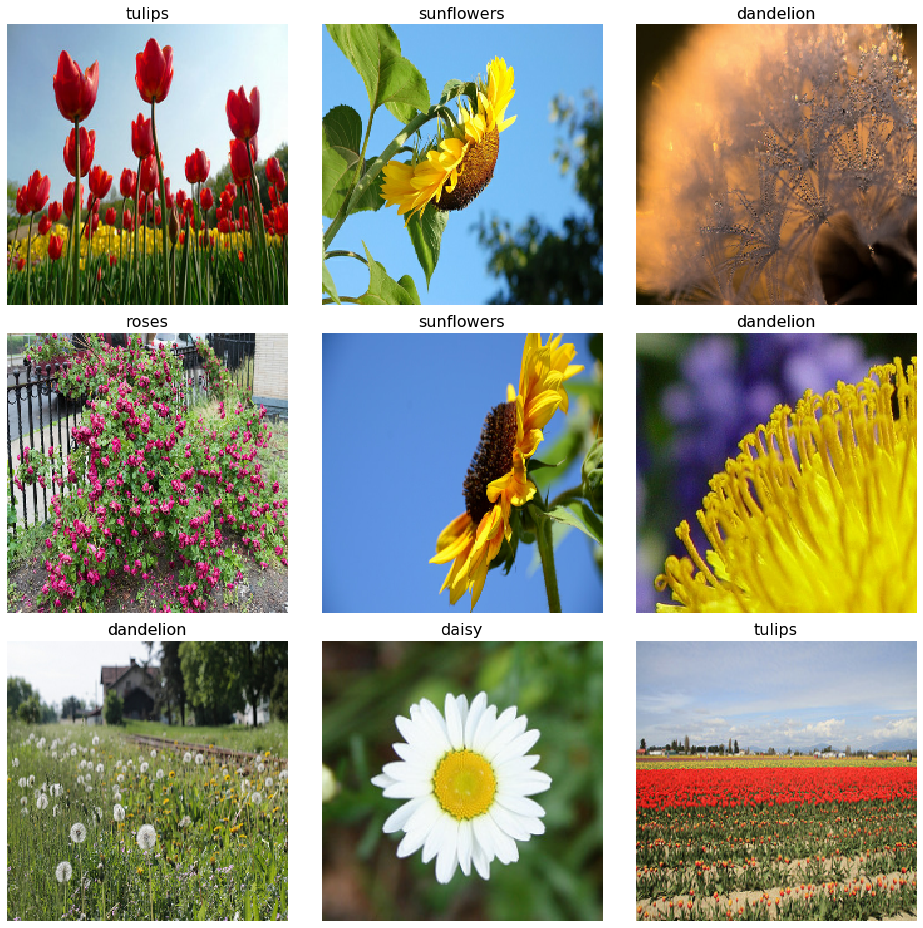

In [19]:
display_dataset = dataset4.map(lambda image, label: (image, label))
display_9_images_from_dataset(display_dataset)

In [0]:
for image,label in dataset4.take(300):
    print("Image shape {}, ({:>10},)".format(image.numpy().shape, label.numpy().decode('utf8')))